In [57]:
import os
import sys
main_path = os.path.abspath(os.path.join("our_method_experimental.ipynb", "..", ".."))
print(main_path)
sys.path.insert(0, main_path)
import numpy as np
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from collections import defaultdict
import time
from scipy import sparse
from src.preprocesing import gen_dataset_from_h5
from src.feature_extraction.text import MPTextGenerator
from src.feature_extraction.vector_space_model import VSM
from src.feature_extraction.centroid import CentroidClass
from src.decomposition import LSA
from src.neighbors import KNeighborsClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, balanced_accuracy_score
import itertools

/home/francisco/Documents/tesis


In [2]:
## fixed parameters
_BANDS = ["lsstg", "lssti", "lsstr", "lsstu", "lssty", "lsstz"]
_N_JOBS = 8

symbols = {
    "mean": "M",
    "std": "S",
    "trend": "T",
    "min_max": "m",
}

In [3]:
def quantities_code(quantities):
    f_name = ""
    for q_i in quantities:
        for q_ii in q_i:
            f_name += symbols[q_ii]
        f_name += "-"
    return f_name

In [4]:
def get_all_single_representations(data, labels, wins, wls, alphabet_size, quantities, classes, doc_kwargs):
    q_code = quantities_code(quantities)
    x_repr = defaultdict(lambda: defaultdict(object))
    for wl, win in zip(wls, wins):
        if True:
            message = "[win: %.3f, wl: %d, q: %s]" % (win, wl, q_code)
            try:
                x_i = multi_quantity_representation(data, win, wl, alphabet_size, quantities, doc_kwargs)
                x_repr[win][wl] = x_i
            except Exception as e:
                print("failed iteration wl=%d, win=%f, error: %s" % (wl, win, e))

    return x_repr

In [5]:
def multi_quantity_representation(data,  win, wl, alphabet_size, q, doc_kwargs):
    if len(q) > 1:
        x_arr = []
        for q_i in q:
            doc_kwargs["quantity"] = np.array(q_i)
            doc_kwargs["alphabet_size"] = np.array([alphabet_size] * len(q_i))
            text_gen = MPTextGenerator(bands=_BANDS, n_jobs=_N_JOBS, win=win, wl=wl, direct_bow=True, tol=wl * 2,
                                       opt_desc=", " + "-".join(q_i), **doc_kwargs)
            x_i = text_gen.fit_transform(data)
            x_arr.append(x_i)
        x = sparse.hstack(x_arr, format="csr")
    else:
        doc_kwargs["quantity"] = np.array(q[0])
        doc_kwargs["alphabet_size"] = np.array([alphabet_size] * len(q[0]))
        text_gen = MPTextGenerator(bands=_BANDS, n_jobs=_N_JOBS, win=win, wl=wl, direct_bow=True, tol=wl * 2,
                                   opt_desc=", " + "-".join(q[0]), **doc_kwargs)
        x = text_gen.fit_transform(data)

    return x

In [65]:
def general_cv_score(x, labels, classes, lsa_kwargs, spatial_comp=100, max_dropped="default", message="X"):
    print("[%s]: DOING CROSS VALIDATION..." % message, end="\r")
    ini = time.time()
    if max_dropped == "default":
        max_dropped = int(0.05 * len(labels))
    dropped = len(np.where(np.sum(x, axis=1) == 0)[0])
    if dropped > max_dropped:
        print("[{}] dropped because {} > {}".format(message, dropped, max_dropped))
        return None, None, None, dropped, [-1, -1]

    shape_before = x.shape[1]
    sel = VarianceThreshold(threshold=0)
    x = sel.fit_transform(x)
    shape_after = x.shape[1]
    # print(shape_before, shape_after)

    # define pipeline for CV score
    vsm = VSM(class_based=False, classes=classes, norm=lsa_kwargs["normalize"], use_idf=lsa_kwargs["use_idf"],
              smooth_idf=True, sublinear_tf=lsa_kwargs["sublinear_tf"])
    lsa = LSA(sc=min(spatial_comp, x.shape[1] - 1), algorithm="randomized", n_iter=5, random_state=None, tol=0.)
    centroid = CentroidClass(classes=classes)
    knn = KNeighborsClassifier(n_neighbors=1, classes=classes, useClasses=lsa_kwargs["class_based"])
    pipeline = Pipeline([("vsm", vsm), ("lsa", lsa), ("centroid", centroid), ("knn", knn)])
    scores = cross_val_score(pipeline, x, labels, scoring="balanced_accuracy", cv=10, n_jobs=_N_JOBS, verbose=0)
    end = time.time()
    print("[%s]: %.3f += %.3f (time: %.3f sec)" % (message, float(np.mean(scores)), float(np.std(scores)), end-ini))
    return scores, pipeline, None, dropped, [shape_before, shape_after]

def general_cv_pred(x, labels, classes, lsa_kwargs, spatial_comp=100, max_dropped="default", message="X"):
    print("[%s]: DOING CROSS VALIDATION..." % message, end="\r")
    ini = time.time()
    if max_dropped == "default":
        max_dropped = int(0.05 * len(labels))
    dropped = len(np.where(np.sum(x, axis=1) == 0)[0])
    if dropped > max_dropped:
        print("[{}] dropped because {} > {}".format(message, dropped, max_dropped))
        return None, None, None, dropped, [-1, -1]

    shape_before = x.shape[1]
    sel = VarianceThreshold(threshold=0)
    x = sel.fit_transform(x)
    shape_after = x.shape[1]
    # print(shape_before, shape_after)

    # define pipeline for CV score
    vsm = VSM(class_based=False, classes=classes, norm=lsa_kwargs["normalize"], use_idf=lsa_kwargs["use_idf"],
              smooth_idf=True, sublinear_tf=lsa_kwargs["sublinear_tf"])
    lsa = LSA(sc=min(spatial_comp, x.shape[1] - 1), algorithm="randomized", n_iter=5, random_state=None, tol=0.)
    centroid = CentroidClass(classes=classes)
    knn = KNeighborsClassifier(n_neighbors=1, classes=classes, useClasses=lsa_kwargs["class_based"])
    pipeline = Pipeline([("centroid", centroid), ("knn", knn)])
    preds = cross_val_predict(pipeline, x, labels, cv=5, n_jobs=_N_JOBS, verbose=1)
    end = time.time()
    return preds

In [7]:
def general_grid_search(data, labels, wins, wls, alphabet_size, q, classes, lsa_kwargs, doc_kwargs, out_path,
                        spatial_comp=100, max_dropped="default"):

    # quantities reduced name
    q_code = quantities_code(q)

    # base name for outpu files
    base_file_name = "multi_ress-%s-stack_" % q_code

    # compute repr for all options
    x_repr, x_score, x_acc_list, win_list, wl_list = get_all_single_representations(data, labels, wins, wls, alphabet_size,
                                                                                    q, classes, lsa_kwargs, doc_kwargs,
                                                                                    spatial_comp=spatial_comp,
                                                                                    max_dropped=max_dropped)
    # save results of first iteration
    save_first_stack(x_score, win_list, wl_list, base_file_name, out_path)

    # rank results by acc
    rank_by_idx = np.argsort(x_acc_list)[::-1]

    # test on top 5 results
    for ii, top_idx in enumerate(rank_by_idx[:5]):
        # incremental config
        x = x_repr[win_list[top_idx]][wl_list[top_idx]]
        record_idxs = [top_idx]
        record_acc = x_acc_list[top_idx]
        print("---> starting stack of configurations for top ", ii+1)
        msg = "[{win,wl}"
        for used_idx in record_idxs:
            msg += ",{%.3f,%d}" % (win_list[used_idx], wl_list[used_idx])
        msg += "]"
        print("---> best config stack 1: %s ::::: acc: %.3f" % (msg, float(record_acc)))
        # stack up until 5 configs
        for k in [2, 3, 4, 5]:
            try:
                print("---> starting search on stack level ", k)
                # define an output file
                out_file = os.path.join(out_path, base_file_name + str(k) + "-top_" + str(ii+1) + "-" + time.strftime("%Y%m%d-%H%M%S") + ".csv")
                f = open(out_file, "a+")
                header = "base,wl,win,dropped,shape_before,shape_after,mean_cv,std_cv,exp_var,n_comp,scheme\n"
                f.write(header)
                f.close()

                # define iter parameters to find best config
                best_config = None
                best_acc = record_acc

                # start iter to find next stack config
                for next_idx in rank_by_idx:
                    # if next_idx was not added to incremental config
                    if next_idx not in record_idxs:
                        # try to stack this idx and check acc
                        try:
                            # generate a compy of the repr matrix
                            x_i = sparse.hstack([x, x_repr[win_list[next_idx]][wl_list[next_idx]]], format="csr")

                            # generate a custom message
                            message = "{win,wl}"
                            for used_idx in record_idxs:
                                message += ",{%.3f,%d}" % (win_list[used_idx], wl_list[used_idx])
                            message += ",{%.3f,%d}" % (win_list[next_idx], wl_list[next_idx])

                            # get a cr score from this current stack of configs
                            score, pipeline, _, dropped, shapes = general_cv_score(x_i, labels, classes, lsa_kwargs,
                                                                           spatial_comp=spatial_comp,
                                                                           max_dropped=max_dropped,
                                                                           message=message)
                            # line to write to file
                            line = "%s,%d,%f,%d,%d,%d," % (message,wl_list[next_idx], win_list[next_idx], dropped, shapes[0], shapes[1])

                            # if the iteration  was invalid (should always be valid here)
                            if score is None and pipeline is None:
                                # raise an error
                                raise ValueError("error")
                            # else
                            else:
                                # generate the rest of the line to write
                                exp_var = np.sum(pipeline["lsa"].explained_variance_ratio_)
                                n_comps = pipeline["lsa"].n_components
                                scheme_name = pipeline["vsm"].get_scheme_notation()
                                mean_cv = float(np.mean(score))
                                std_cv = float(np.std(score))
                                line += "%f,%f,%f,%d,%s\n" % (mean_cv, std_cv,
                                                      exp_var if exp_var is not None else -1,
                                                      pipeline["lsa"].n_components,
                                                      pipeline["vsm"].get_scheme_notation())

                                # and if this stack is the best so far, update variables
                                if mean_cv > best_acc:
                                    best_config = record_idxs + [next_idx]
                                    best_acc = mean_cv
                        except Exception as e:
                            print("failed on stack step k=%d, for wl=%d, win=%f, error: %s" % (k, wl_list[next_idx], win_list[next_idx], e))
                        else:

                            # write line to file
                            f = open(out_file, "a+")
                            try:
                                f.write(line)
                            except:
                                f.close()
                            else:
                                f.close()

                # after the iteration, if no improvement was achieve, stop the process
                if best_config is None or best_acc <= record_acc:
                    print("ACCURACY IS NOT IMPROVING, STOPPING CODE")
                    break
                else:
                    # update the incremental configuration and advance to next stack level
                    x_arr = []
                    for used_idx in best_config:
                        x_arr.append(x_repr[win_list[used_idx]][wl_list[used_idx]])
                    x = sparse.hstack(x_arr, format="csr")
                    record_idxs = best_config
                    record_acc = best_acc
                    msg = "[{win,wl}"
                    for used_idx in record_idxs:
                        msg += ",{%.3f,%d}" % (win_list[used_idx], wl_list[used_idx])
                    msg += "]"
                    print("---> best config stack %d: %s ::::: acc: %.3f" % (k, msg, float(record_acc)))
            except Exception as e:
                print("failed stack step k=%d, error: %s" % (k, e))

In [8]:
set_name = "plasticc_train"
dataset, labels_, metadata = gen_dataset_from_h5(set_name)
classes = np.unique(labels_)

Object: 100%|██████████| 7848/7848 [00:00<00:00, 199994.52it/s]


In [9]:
time_durations = np.array(
        [ts.observations["time"].to_numpy()[-1] - ts.observations["time"].to_numpy()[0] for ts in dataset])
mean_time = np.mean(time_durations)
std_time = np.std(time_durations)
max_window = mean_time + std_time

doc_kwargs = {
        "irr_handler": "#",
        "mean_bp_dist": "normal",
        "verbose": True,
    }

lsa_kwargs = {
        "class_based": True, # options: True, False
        "normalize": "l2", # options: None, l2
        "use_idf": True, # options: True, False
        "sublinear_tf": True # options: True, False
}

alphabet_size = 6
q = [["mean", "trend", "min_max"]]

In [10]:
out_path = os.path.join(main_path, "data", "configs_results", "multi_ress_search")

In [11]:
wls = [1, 1, 2, 1, 2]
wins = [94.472, 1047.782, 400.206, 110.909, 892.496]

In [12]:
x_repr = get_all_single_representations(dataset, labels_, wins, wls, alphabet_size,
                                        q, classes,  doc_kwargs)

(7848, 653)
(7848, 1229)
(7848, 17306)
(7848, 17958)
(7848, 25164)


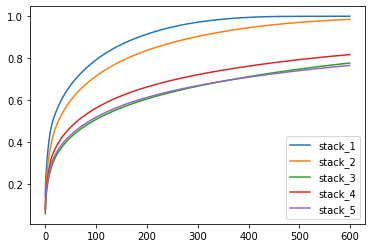

In [29]:
x_arr = []
fig = plt.plot()
i = 1
for wl, win in zip(wls[:], wins[:]):
    x_arr.append(x_repr[win][wl])
    x_i = sparse.hstack(x_arr, format="csr")
    sel = VarianceThreshold(threshold=0)
    x_i = sel.fit_transform(x_i)
    print(x_i.shape)
    lsa = TruncatedSVD(n_iter=5, n_components=600).fit(x_i)
    plt.plot(np.cumsum(lsa.explained_variance_ratio_), label="stack_%d" % (i))
    i+=1
    
plt.legend()

# x = sparse.hstack(x_arr, format="csr")
# x.shape

In [30]:
x_i.shape

(7848, 25164)

In [42]:
score, pipeline, _, dropped, shapes = general_cv_score(x_i, labels_, classes, lsa_kwargs, spatial_comp=500, max_dropped="default", message="X")

[X]: 0.491 += 0.016 (time: 162.102 sec)


In [43]:
score2, pipeline, _, dropped2, shapes2 = general_cv_score(x_i, labels_, classes, lsa_kwargs, spatial_comp=1000, max_dropped="default", message="X")

[X]: 0.498 += 0.019 (time: 365.594 sec)


In [44]:
score4, pipeline, _, dropped2, shapes4 = general_cv_score(x_i, labels_, classes, lsa_kwargs, spatial_comp=250, max_dropped="default", message="X")

[X]: 0.486 += 0.013 (time: 90.998 sec)


In [45]:
score3, pipeline, _, dropped2, shapes3 = general_cv_score(x_i, labels_, classes, lsa_kwargs, spatial_comp=362, max_dropped="default", message="X")

[X]: 0.486 += 0.013 (time: 120.133 sec)


In [46]:
sc = int(np.mean([len(ts.observations["flux"]) * 2 for ts in dataset]))
sc

362

<ErrorbarContainer object of 3 artists>

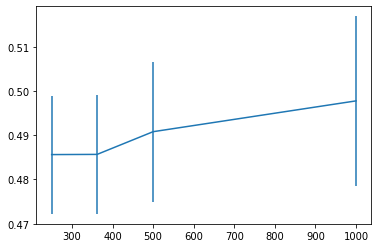

In [47]:
y = [np.mean(score4), np.mean(score3), np.mean(score), np.mean(score2)]
yerr = [np.std(score4), np.std(score3), np.std(score), np.std(score2)]
x = [250, 362, 500, 1000]
plt.errorbar(x, y, yerr=yerr)

In [52]:
preds = general_cv_pred(x_i, labels_, classes, lsa_kwargs, spatial_comp=500, max_dropped="default", message="X")

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:  1.1min remaining:  1.7min
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:  1.2min finished


In [56]:
conf = confusion_matrix(labels_, preds)
acc = balanced_accuracy_score(labels_, preds)
acc

0.4841672067322361

In [58]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap="YlGnBu"):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=17)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right")
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=14)

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()

Confusion matrix, without normalization


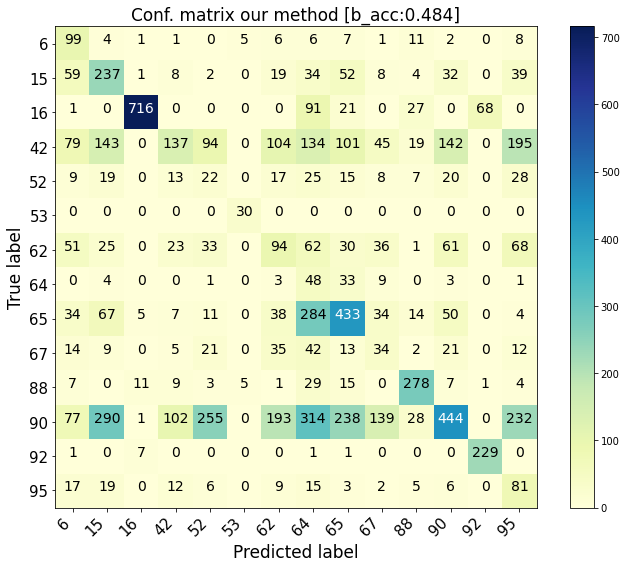

In [59]:
fig = plt.figure(figsize=(10,8))
plot_confusion_matrix(conf, classes=classes, normalize=False,
                     title="Conf. matrix our method [b_acc:%.3f]" % acc)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:   17.0s remaining:   25.5s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:   21.3s finished


Normalized confusion matrix
Confusion matrix, without normalization


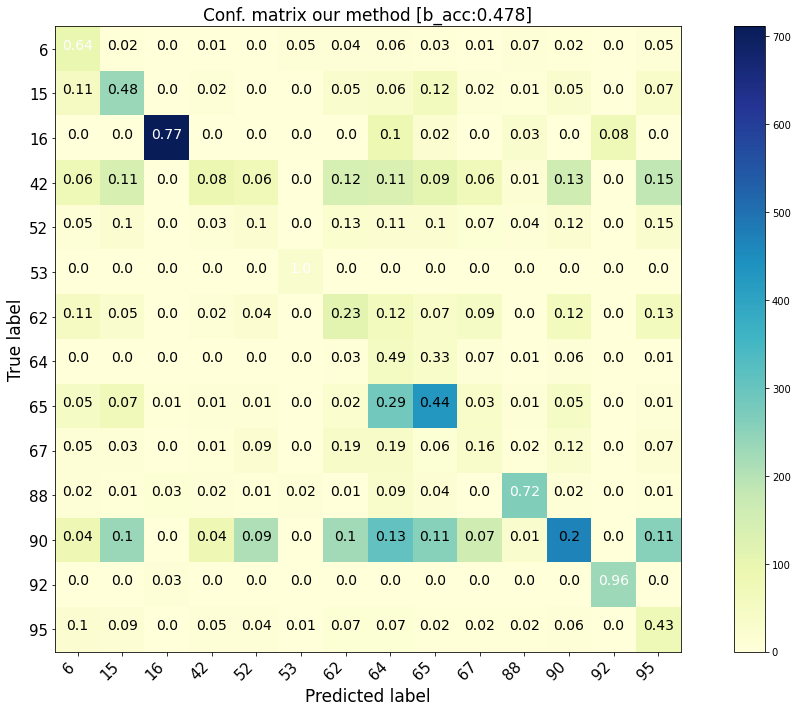

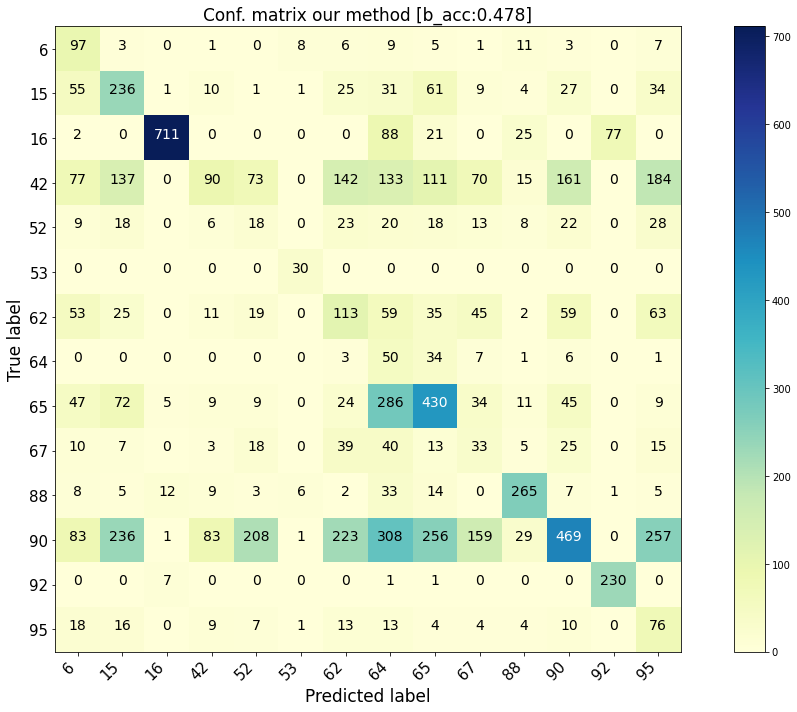

In [62]:

x_arr = []
i = 1
for wl, win in zip(wls[:2], wins[:2]):
    x_arr.append(x_repr[win][wl])
    
x_i = sparse.hstack(x_arr, format="csr")
sel = VarianceThreshold(threshold=0)
x_i = sel.fit_transform(x_i)

preds = general_cv_pred(x_i, labels_, classes, lsa_kwargs, spatial_comp=500, max_dropped="default", message="X")

conf = confusion_matrix(labels_, preds)
acc = balanced_accuracy_score(labels_, preds)

fig = plt.figure(figsize=(15,10))
plot_confusion_matrix(conf, classes=classes, normalize=True,
                     title="Conf. matrix our method [b_acc:%.3f]" % acc)

fig = plt.figure(figsize=(15,10))
plot_confusion_matrix(conf, classes=classes, normalize=False,
                     title="Conf. matrix our method [b_acc:%.3f]" % acc)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:   10.3s remaining:   15.4s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:   12.7s finished


Normalized confusion matrix
Confusion matrix, without normalization


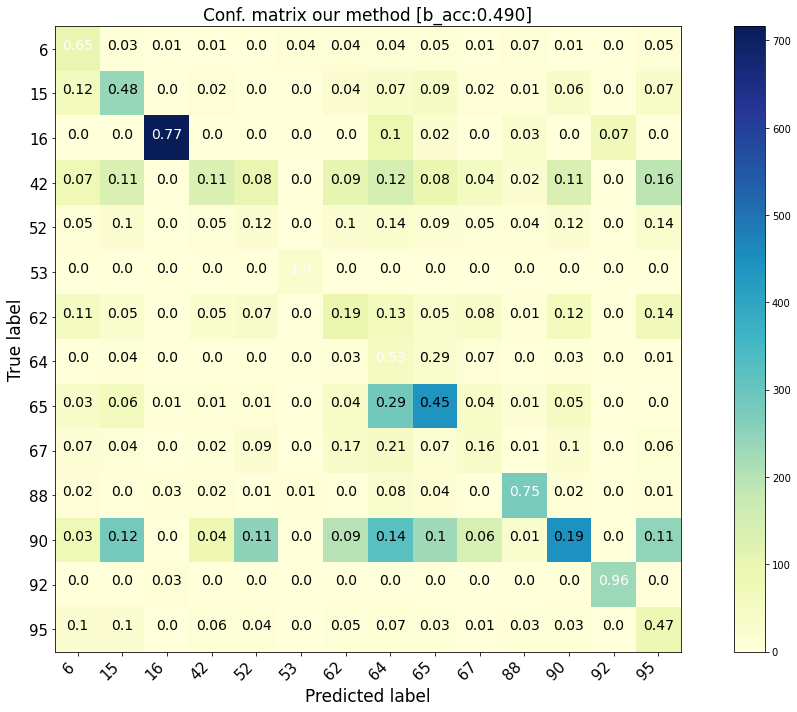

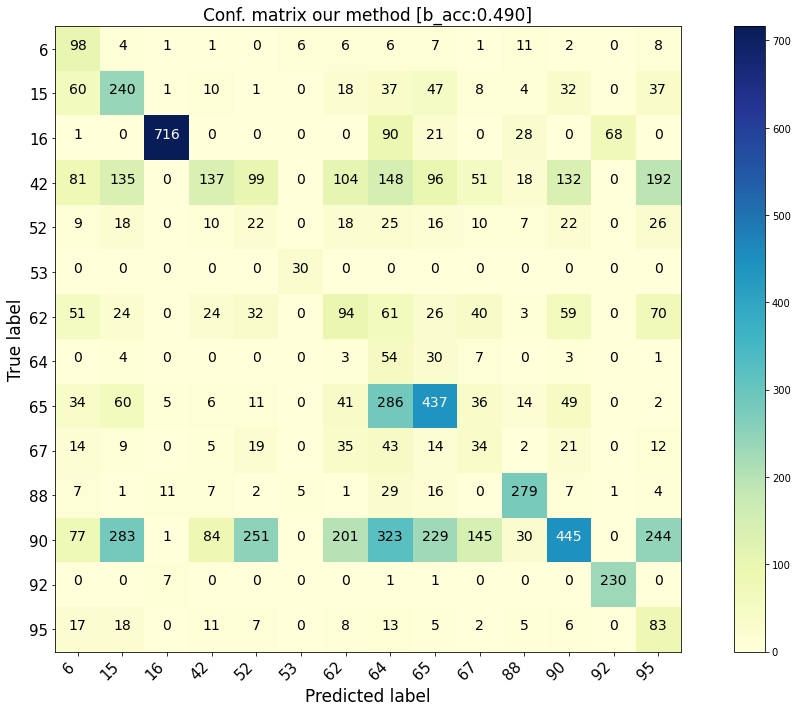

In [66]:

x_arr = []
i = 1
for wl, win in zip(wls[:5], wins[:5]):
    x_arr.append(x_repr[win][wl])
    
x_i = sparse.hstack(x_arr, format="csr")
sel = VarianceThreshold(threshold=0)
x_i = sel.fit_transform(x_i)
vsm = VSM(class_based=False, classes=classes, norm=lsa_kwargs["normalize"], use_idf=lsa_kwargs["use_idf"],
              smooth_idf=True, sublinear_tf=lsa_kwargs["sublinear_tf"])
x_i = vsm.fit_transform(x_i, y=labels_)
lsa = TruncatedSVD(n_components=500)
x_i = lsa.fit_transform(x_i, y=labels_)
preds = general_cv_pred(x_i, labels_, classes, lsa_kwargs, spatial_comp=500, max_dropped="default", message="X")

conf = confusion_matrix(labels_, preds)
acc = balanced_accuracy_score(labels_, preds)

fig = plt.figure(figsize=(15,10))
plot_confusion_matrix(conf, classes=classes, normalize=True,
                     title="Conf. matrix our method [b_acc:%.3f]" % acc)

fig = plt.figure(figsize=(15,10))
plot_confusion_matrix(conf, classes=classes, normalize=False,
                     title="Conf. matrix our method [b_acc:%.3f]" % acc)

In [67]:
x_i[45][56]

0.04825724374254988